# nbeats 실험 추세성, 잔차
---
- 샘플사이즈에 따른 최적 에포크
- 시뮬레이션 데이터 
    - 추세
    - 잔차

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nbeats_keras.model import NBeatsNet as NBeatsKeras
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
#from nbeats_pytorch.model import NBeatsNet as NBeatsPytorch
from keras.optimizers import RMSprop, Adam
import time
#from pretraindata_simulation72_24_scale import sclae_X_train,sclae_y_train

from sklearn.metrics import mean_squared_error,mean_absolute_error,mean_absolute_percentage_error
plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, TimeDistributed, Lambda
from tensorflow.keras.callbacks import EarlyStopping

In [648]:
##############################################################################################################
def window(df, timestep):
    '''
    단변량 데이터를 timestep에 따라 window로 생성하는 함수
    
    '''
    for i in range(0, timestep):
        df['shift_{}'.format(i)] = df.iloc[:,0].shift(i)
        df['shift_{}'.format(i)] = df.iloc[:,0].shift(i)
    window_df = df.dropna(axis=0) # 결측치 공간 제거
    window_df = window_df.iloc[:,::-1] # 좌우 반전


    feature= window_df.iloc[:,:-1].values
    y_label= window_df.iloc[:,-1].values

    return feature

##############################################################################################################
def generate_time(t,    
                  cosine_period1=24,
                    cosine_period2=1,
                    cosine_period3=1,
                    sine_period1=1,
                    sine_period2=1,
                    sine_period3=1,
                    cosine_slope1=1,
                    cosine_slope2=2,
                    cosine_slope3=3,
                    sine_slope1=1,
                    sine_slope2=2,
                    sine_slope3=3,
                    trend_slope = 0,
                  noise_level=0.1):
    '''
    cosin, sin, trend, 기울기 등을 결합하여 데이터 생성
    y = b1*cos(2*pi*t/period) + b2*cos(2*pi*t/period) + b3*t + epsilon
    '''
    series = (cosine_slope1 * np.cos(2 * np.pi / cosine_period1 * (t )) +
              cosine_slope2 * np.cos(2 * np.pi / cosine_period2 * (t )) +
              cosine_slope3 * np.cos(2 * np.pi / cosine_period3 * (t )) +
              sine_slope1 * np.sin(2 * np.pi / sine_period1 * (t )) + 
              sine_slope2 * np.sin(2 * np.pi / sine_period2 * (t )) + 
              sine_slope3 * np.sin(2 * np.pi / sine_period3 * (t )) + 
              trend_slope * t )


    # Add Gaussian noise
    noise = noise_level * np.random.randn(len(t))
    series += noise

    return series
##############################################################################################################

def random_parameters():
    '''
    랜덤 파라미터
    '''
    cosine_slope1=round(np.random.uniform(-1,1),2),
    cosine_slope2=round(np.random.uniform(-1,1),2),
    cosine_slope3=round(np.random.uniform(-1,1),2),
    sine_slope1=round(np.random.uniform(-1,1),2),
    sine_slope2=round(np.random.uniform(-1,1),2),
    sine_slope3=round(np.random.uniform(-1,1),2)

    return cosine_slope1,cosine_slope2,cosine_slope3,sine_slope1,sine_slope2,sine_slope3
##############################################################################################################

def generate_random_ts(t):
    '''
    랜덤 파라미터에 의한 데이터 생성
    '''
    cosine_slope1,cosine_slope2,cosine_slope3,sine_slope1,sine_slope2,sine_slope3= random_parameters()
    
    random_ts= generate_time(t,
                            cosine_slope1 = cosine_slope1,
                             cosine_slope2 = cosine_slope2,
                             cosine_slope3=cosine_slope3,
                             sine_slope1 = sine_slope1,
                             sine_slope2= sine_slope2,
                             sine_slope3=sine_slope3)
    
    return random_ts
##############################################################################################################

def split_train_test(list_in_array, horizon, lookback):
    '''
    train_test 모형 적합 전처리 함수
    1. train, test 분리
    2. input, output 분리
    '''
    
    train = np.array([list_in_array[i][:-horizon*(lookback+1)] for i in range(len(list_in_array))])
    test = np.array([list_in_array[i][-horizon*(lookback+1):] for i in range(len(list_in_array))])
    #from sklearn.preprocessing import MinMaxScaler
    #minmax = MinMaxScaler()
    #scale = minmax.fit_transform(pd.concat([pd.DataFrame(train), pd.DataFrame(test)],axis=1))
    
    #train = np.array([scale[i][:-horizon*(lookback+1)] for i in range(len(scale))])
    #test = np.array([scale[i][-horizon*(lookback+1):] for i in range(len(scale))])
    
    window_train= [window(pd.DataFrame(train[i]),horizon*(lookback+1)) for i in range(len(train))]
    X_train = [window_train[i][:,:-horizon] for i in range(len(window_train))]
    y_train = [window_train[i][:,-horizon:] for i in range(len(window_train))]
    X_test = test[:,:-horizon]#.reshape(-1,1)
    y_test = test[:,-horizon:]#.reshape(-1,1)
    
    X_test = [X_test[i].reshape(1,-1) for i in range(len(X_test))]
    y_test = [y_test[i].reshape(1,-1) for i in range(len(y_test))]
    
    
    return X_train ,y_train, X_test,y_test



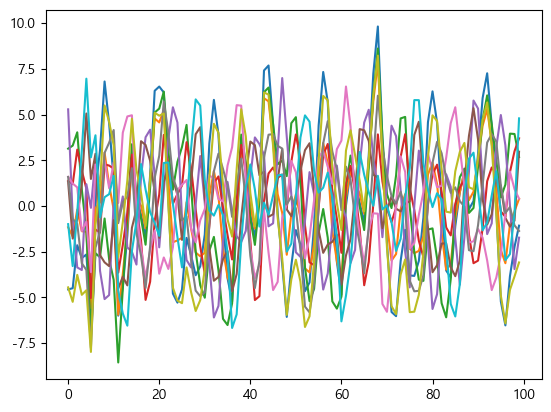

In [1017]:
random_simul = []
for i in range(10):
    ramdom_ts = generate_time(t1000 ,24,12,6,24,12,6,
                               round(np.random.uniform(-3,3),2),
                               round(np.random.uniform(-3,3),2),
                               round(np.random.uniform(-3,3),2),
                               round(np.random.uniform(-3,3),2),
                               round(np.random.uniform(-3,3),2),
                               round(np.random.uniform(-3,3),2),
                               0,0) + e
    np.array(random_simul.append(ramdom_ts ))
plt.plot(np.array(random_simul).T[:100]);

In [679]:
np.random.seed(1)
horizon = 24
lookback = 3
t = 1191
t1000 = np.arange(0,t)
e = np.random.normal(0,1,t)

#simul_base     = [generate_time(t_lst[i],24,12,6,24,12,6,1,1,1,1,1,1,0,0) for i in range(3)]
simul_no_trend = generate_time(t1000 ,24,12,6,24,12,6,1,1,1,1,1,1,0,0) + e
simul_yes_trend = generate_time(t1000 ,24,12,6,24,12,6,1,1,1,1,1,1,0.05,0)  + e
simul_low_epsilon = generate_time(t1000 ,24,12,6,24,12,6,1,1,1,1,1,1,0,0) + e/3
simul_high_epsilon = generate_time(t1000 ,24,12,6,24,12,6,1,1,1,1,1,1,0,0) + e*3


#simul_cos24= [generate_time(t1000 ,24,12,6,24,12,6,np.random.uniform(-3,3),1,1,1,1,1,0,1) for i in range(100)]
#simul_cos12=[generate_time(t1000 ,24,12,6,24,12,6,1,np.random.uniform(-3,3),1,1,1,1,0,1) for i in range(100)]
#simul_cos6=[generate_time(t1000 ,24,12,6,24,12,6,1,1,np.random.uniform(-3,3),1,1,1,0,1) for i in range(100)]
#simul_cos24=[generate_time(t1000 ,24,12,6,24,12,6,1,1,1,np.random.uniform(-3,3),1,1,0,1) for i in range(100)]
#simul_cos12=[generate_time(t1000 ,24,12,6,24,12,6,1,1,1,1,np.random.uniform(-3,3),1,0,1) for i in range(100)]
#simul_cos6=[generate_time(t1000 ,24,12,6,24,12,6,1,1,1,1,1,np.random.uniform(-3,3),0,1) for i in range(100)]
#plt.plot(generate_time(t1000,24,12,6,24,12,6,1,1,1,1,0.1,1,0.05,1)[:1000])



X_train_nt100 ,y_train_nt100, X_test_nt100,y_test_nt100 = split_train_test([simul_no_trend[-291:].round(3)],horizon,lookback )
X_train_nt500 ,y_train_nt500, X_test_nt500,y_test_nt500 = split_train_test([simul_no_trend[-691:].round(3)],horizon,lookback )
X_train_nt1000 ,y_train_nt1000, X_test_nt1000,y_test_nt1000 = split_train_test([simul_no_trend.round(3)],horizon,lookback )

X_train_yt100 ,y_train_yt100, X_test_yt100,y_test_yt100 = split_train_test([simul_yes_trend[-291:].round(3)],horizon,lookback )
X_train_yt500 ,y_train_yt500, X_test_yt500,y_test_yt500 = split_train_test([simul_yes_trend[-691:].round(3)],horizon,lookback )
X_train_yt1000 ,y_train_yt1000, X_test_yt1000,y_test_yt1000 = split_train_test([simul_yes_trend.round(3)],horizon,lookback )


X_train_le100 ,y_train_le100, X_test_le100,y_test_le100 = split_train_test([simul_low_epsilon[-291:].round(3)],horizon,lookback )
X_train_le500 ,y_train_le500, X_test_le500,y_test_le500 = split_train_test([simul_low_epsilon[-691:].round(3)],horizon,lookback )
X_train_le1000 ,y_train_le1000, X_test_le1000,y_test_le1000 = split_train_test([simul_low_epsilon.round(3)],horizon,lookback )

X_train_he100 ,y_train_he100, X_test_he100,y_test_he100 = split_train_test([simul_high_epsilon [-291:].round(3)],horizon,lookback )
X_train_he500 ,y_train_he500, X_test_he500,y_test_he500 = split_train_test([simul_high_epsilon [-691:].round(3)],horizon,lookback )
X_train_he1000 ,y_train_he1000, X_test_he1000,y_test_he1000 = split_train_test([simul_high_epsilon .round(3)],horizon,lookback )


In [708]:
horizon = 24
lookback = 3

X_train_nt100 ,y_train_nt100, X_test_nt100,y_test_nt100 = split_train_test([simul_no_trend[-291:].round(3)],horizon,lookback )
X_train_nt500 ,y_train_nt500, X_test_nt500,y_test_nt500 = split_train_test([simul_no_trend[-691:].round(3)],horizon,lookback )
X_train_nt1000 ,y_train_nt1000, X_test_nt1000,y_test_nt1000 = split_train_test([simul_no_trend.round(3)],horizon,lookback )

X_train_yt100 ,y_train_yt100, X_test_yt100,y_test_yt100 = split_train_test([simul_yes_trend[-291:].round(3)],horizon,lookback )
X_train_yt500 ,y_train_yt500, X_test_yt500,y_test_yt500 = split_train_test([simul_yes_trend[-691:].round(3)],horizon,lookback )
X_train_yt1000 ,y_train_yt1000, X_test_yt1000,y_test_yt1000 = split_train_test([simul_yes_trend.round(3)],horizon,lookback )


X_train_le100 ,y_train_le100, X_test_le100,y_test_le100 = split_train_test([simul_low_epsilon[-291:].round(3)],horizon,lookback )
X_train_le500 ,y_train_le500, X_test_le500,y_test_le500 = split_train_test([simul_low_epsilon[-691:].round(3)],horizon,lookback )
X_train_le1000 ,y_train_le1000, X_test_le1000,y_test_le1000 = split_train_test([simul_low_epsilon.round(3)],horizon,lookback )

X_train_he100 ,y_train_he100, X_test_he100,y_test_he100 = split_train_test([simul_high_epsilon [-291:].round(3)],horizon,lookback )
X_train_he500 ,y_train_he500, X_test_he500,y_test_he500 = split_train_test([simul_high_epsilon [-691:].round(3)],horizon,lookback )
X_train_he1000 ,y_train_he1000, X_test_he1000,y_test_he1000 = split_train_test([simul_high_epsilon .round(3)],horizon,lookback )



In [900]:
X_test_nt100[0].shape

(1, 72)

## setting

In [778]:

# nbeats 파라미터
input_dim, output_dim =  1, 1
backcast= horizon*lookback
forecast = horizon #7



def build_model(input_timesteps=backcast, output_timesteps=horizon, features=1):
    model = Sequential()
    model.add(LSTM(128, return_sequences=True, input_shape=(input_timesteps, features)))
    # Use Lambda layer to select the last 'output_timesteps' outputs
    model.add(Lambda(lambda x: x[:, -output_timesteps:, :]))
    model.add(TimeDistributed(Dense(1)))
    model.compile(loss='mse', optimizer='adam')
    return model

## 에포크 설정
- 보통 200이하에서 끊김

In [831]:
epoch = 200
batch_size = 4
X_train,y_train,X_test,y_test = X_train_nt100[0] ,y_train_nt100[0], X_test_nt100[0],y_test_nt100[0]

for i in range(Num):
    K.clear_session()
    model= NBeatsKeras( backcast_length=backcast, forecast_length=forecast, input_dim=input_dim,
                       output_dim=output_dim,stack_types=(NBeatsKeras.TREND_BLOCK,NBeatsKeras.TREND_BLOCK,
                                                          NBeatsKeras.SEASONALITY_BLOCK,NBeatsKeras.SEASONALITY_BLOCK)
                       ,nb_blocks_per_stack=4, thetas_dim=(1,2,4,4),
                       share_weights_in_stack=True, hidden_layer_units=128)
    optimizer = Adam(learning_rate=0.001)
    model.compile(loss='mse', optimizer=optimizer )

    early_stop = EarlyStopping(monitor='loss', patience=5, verbose=0, restore_best_weights=False)
    #checkpoint = ModelCheckpoint('best_model.h9', monitor='loss', save_best_only=True, mode='max', verbose=1)
    #model.save('best_model.h9')
    nbeat_time1 = time.time()
    history1 = model.fit(X_train,y_train,validation_data=(X_test,y_test),
                        epochs=epoch , batch_size=batch_size, verbose=0,
                        callbacks=[early_stop])
    nbeat_time2 = time.time()
    

###    
X_train,y_train,X_test,y_test = X_train_nt500[0] ,y_train_nt500[0], X_test_nt500[0],y_test_nt500[0]
for i in range(Num):
    K.clear_session()
    model= NBeatsKeras( backcast_length=backcast, forecast_length=forecast, input_dim=input_dim,
                       output_dim=output_dim,stack_types=(NBeatsKeras.TREND_BLOCK,NBeatsKeras.TREND_BLOCK,
                                                          NBeatsKeras.SEASONALITY_BLOCK,NBeatsKeras.SEASONALITY_BLOCK)
                       ,nb_blocks_per_stack=4, thetas_dim=(1,2,4,4),
                       share_weights_in_stack=True, hidden_layer_units=128)
    optimizer = Adam(learning_rate=0.001)
    model.compile(loss='mse', optimizer=optimizer )

    early_stop = EarlyStopping(monitor='loss', patience=5, verbose=0, restore_best_weights=False)
    #checkpoint = ModelCheckpoint('best_model.h9', monitor='loss', save_best_only=True, mode='max', verbose=1)
    #model.save('best_model.h9')
    nbeat_time1 = time.time()
    history2 = model.fit(X_train,y_train,validation_data=(X_test,y_test),
                        epochs=epoch , batch_size=batch_size, verbose=0,
                        callbacks=[early_stop])
    
### 
X_train,y_train,X_test,y_test = X_train_nt1000[0] ,y_train_nt1000[0], X_test_nt1000[0],y_test_nt1000[0]

for i in range(Num):
    K.clear_session()
    model= NBeatsKeras( backcast_length=backcast, forecast_length=forecast, input_dim=input_dim,
                       output_dim=output_dim,stack_types=(NBeatsKeras.TREND_BLOCK,NBeatsKeras.TREND_BLOCK,
                                                          NBeatsKeras.SEASONALITY_BLOCK,NBeatsKeras.SEASONALITY_BLOCK)
                       ,nb_blocks_per_stack=4, thetas_dim=(1,2,4,4),
                       share_weights_in_stack=True, hidden_layer_units=128)
    optimizer = Adam(learning_rate=0.001)
    model.compile(loss='mse', optimizer=optimizer )

    early_stop = EarlyStopping(monitor='loss', patience=5, verbose=0, restore_best_weights=False)
    #checkpoint = ModelCheckpoint('best_model.h9', monitor='loss', save_best_only=True, mode='max', verbose=1)
    #model.save('best_model.h9')
    nbeat_time1 = time.time()
    history3 = model.fit(X_train,y_train,validation_data=(X_test,y_test),
                        epochs=epoch , batch_size=batch_size, verbose=0,
                        callbacks=[early_stop])
    
print("fin")

fin


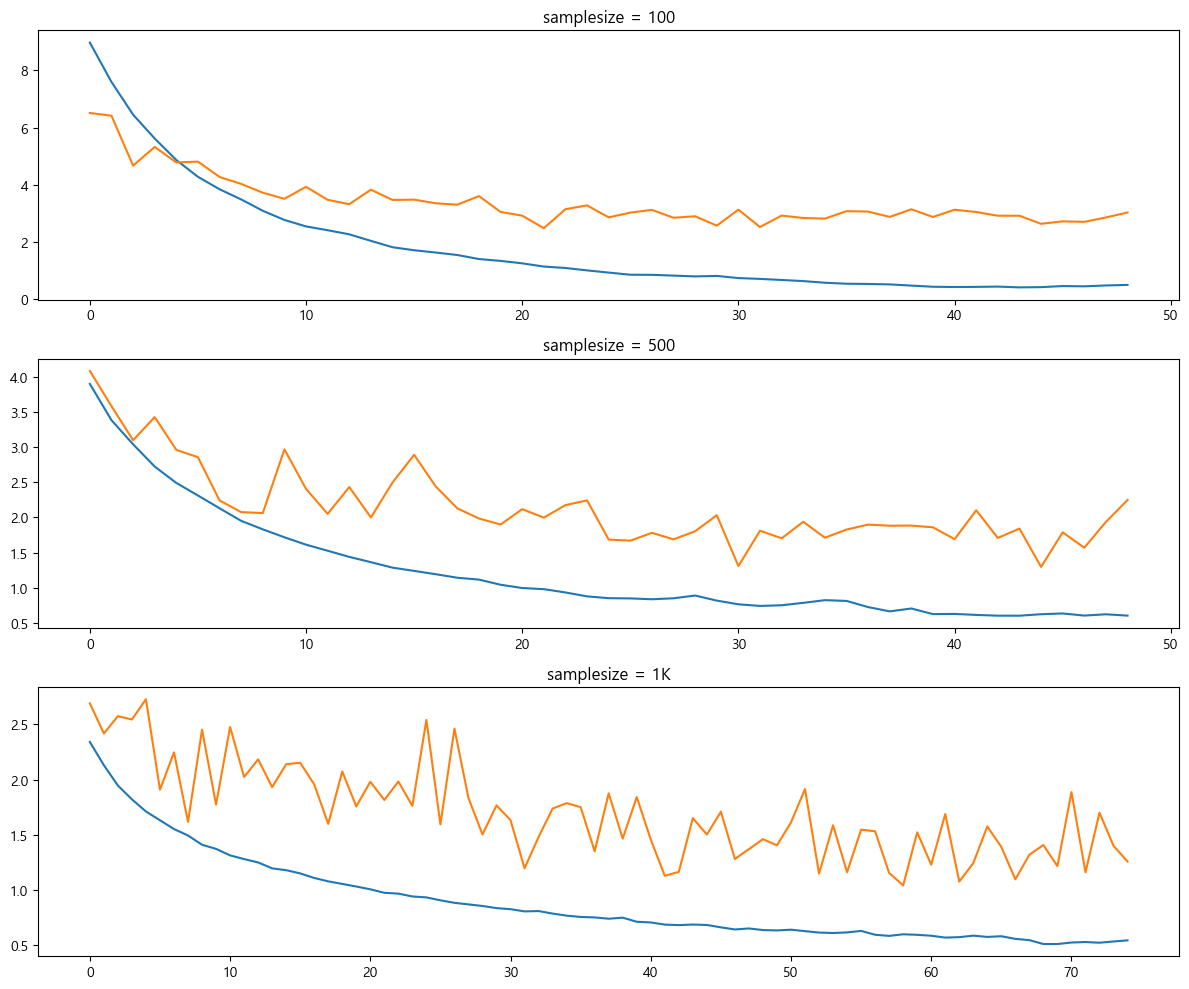

In [832]:
fig, axe = plt.subplots(3,1,figsize = (12,10))

axe[0].plot(history1.history['loss'][5:100])
axe[0].plot(history1.history['val_loss'][5:100])
axe[0].set_title('samplesize = 100')


axe[1].plot(history2.history['loss'][5:100])
axe[1].plot(history2.history['val_loss'][5:100])
axe[1].set_title('samplesize = 500')


axe[2].plot(history3.history['loss'][5:100])
axe[2].plot(history3.history['val_loss'][5:100])
axe[2].set_title('samplesize = 1K')



 
#axe[1,1].plot(simul_high_epsilon[:n] )
#axe[1,1].set_title('epsilon $\sim N(0,9)$')

plt.tight_layout()
plt.show()

---
## no trend
---

In [833]:
Num= 1
epoch = 20
batch_size = 4

In [834]:

##################################################################################################
## sample size = 100, no trend
#######################################################################################################################################

X_train,y_train,X_test,y_test = X_train_nt100[0] ,y_train_nt100[0], X_test_nt100[0],y_test_nt100[0]

nbeats_nt100_score = []
nbeats_nt100_lst = []
nbeats_nt100_time = []



for i in range(Num):
    K.clear_session()
    model= NBeatsKeras( backcast_length=backcast, forecast_length=forecast, input_dim=input_dim,
                       output_dim=output_dim,stack_types=(NBeatsKeras.TREND_BLOCK,NBeatsKeras.TREND_BLOCK,
                                                          NBeatsKeras.SEASONALITY_BLOCK,NBeatsKeras.SEASONALITY_BLOCK)
                       ,nb_blocks_per_stack=4, thetas_dim=(1,2,4,4),
                       share_weights_in_stack=True, hidden_layer_units=128)
    optimizer = Adam(learning_rate=0.001)
    model.compile(loss='mse', optimizer=optimizer )

    early_stop = EarlyStopping(monitor='loss', patience=5, verbose=0, restore_best_weights=False)
    #checkpoint = ModelCheckpoint('best_model.h9', monitor='loss', save_best_only=True, mode='max', verbose=1)
    #model.save('best_model.h9')
    nbeat_time1 = time.time()
    history = model.fit(X_train,y_train,validation_data=(X_test,y_test),
                        epochs=epoch , batch_size=batch_size, verbose=0,
                        callbacks=[early_stop])
    nbeat_time2 = time.time()
    
    pred = model.predict(X_test)
    me1= mean_squared_error(y_test.flatten(),pred.flatten())
    me2=mean_absolute_error(y_test.flatten(),pred.flatten())
    me3=mean_absolute_percentage_error(y_test.flatten(),pred.flatten())
    
    nbeats_nt100_lst.append(pred.flatten())
    nbeats_nt100_score.append([me1,me2,me3])
    nbeats_nt100_time.append(nbeat_time2-nbeat_time1)
    
#######################################################################################################################################


lstm_nt100_score = []
lstm_nt100_lst = []
lstm_nt100_time = []

for i in range(Num):
    K.clear_session()
    lstm_model = build_model()
    early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
    time1 = time.time()
    history = lstm_model.fit(X_train, y_train,validation_data=(X_test,y_test), 
                        epochs=epoch , batch_size=batch_size, verbose=0, callbacks=[early_stop])
    time2 = time.time()    
    pred = lstm_model.predict(X_test)
    me1= mean_squared_error(y_test.flatten(),pred.flatten())
    me2=mean_absolute_error(y_test.flatten(),pred.flatten())
    me3=mean_absolute_percentage_error(y_test.flatten(),pred.flatten())
    
    lstm_nt100_lst.append(pred.flatten())
    lstm_nt100_score.append([me1,me2,me3])
    lstm_nt100_time.append(time2-time1)
    

##################################################################################################
# sample size = 500 , no trend
##############################################################################################################    
X_train,y_train,X_test,y_test = X_train_nt500[0] ,y_train_nt500[0], X_test_nt500[0],y_test_nt500[0]

nbeats_nt500_score = []
nbeats_nt500_lst = []
nbeats_nt500_time = []



for i in range(Num):
    K.clear_session()
    model= NBeatsKeras( backcast_length=backcast, forecast_length=forecast, input_dim=input_dim,
                       output_dim=output_dim,stack_types=(NBeatsKeras.TREND_BLOCK,NBeatsKeras.TREND_BLOCK,
                                                          NBeatsKeras.SEASONALITY_BLOCK,NBeatsKeras.SEASONALITY_BLOCK)
                       ,nb_blocks_per_stack=4, thetas_dim=(1,2,4,4),
                       share_weights_in_stack=True, hidden_layer_units=128)
    optimizer = Adam(learning_rate=0.001)
    model.compile(loss='mse', optimizer=optimizer )

    early_stop = EarlyStopping(monitor='loss', patience=5, verbose=0, restore_best_weights=False)
    #checkpoint = ModelCheckpoint('best_model.h9', monitor='loss', save_best_only=True, mode='max', verbose=1)
    #model.save('best_model.h9')
    nbeat_time1 = time.time()
    history = model.fit(X_train,y_train,validation_data=(X_test,y_test),
                        epochs=epoch , batch_size=batch_size, verbose=0,
                        callbacks=[early_stop])
    nbeat_time2 = time.time()
    
    pred = model.predict(X_test)
    me1= mean_squared_error(y_test.flatten(),pred.flatten())
    me2=mean_absolute_error(y_test.flatten(),pred.flatten())
    me3=mean_absolute_percentage_error(y_test.flatten(),pred.flatten())
    
    nbeats_nt500_lst.append(pred.flatten())
    nbeats_nt500_score.append([me1,me2,me3])
    nbeats_nt500_time.append(nbeat_time2-nbeat_time1)
    
#######################################################################################################################################


lstm_nt500_score = []
lstm_nt500_lst = []
lstm_nt500_time = []

for i in range(Num):
    K.clear_session()
    lstm_model = build_model()
    early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
    time1 = time.time()
    history = lstm_model.fit(X_train, y_train,validation_data=(X_test,y_test), 
                        epochs=epoch , batch_size=batch_size, verbose=0, callbacks=[early_stop])
    time2 = time.time()    
    pred = lstm_model.predict(X_test)
    me1= mean_squared_error(y_test.flatten(),pred.flatten())
    me2=mean_absolute_error(y_test.flatten(),pred.flatten())
    me3=mean_absolute_percentage_error(y_test.flatten(),pred.flatten())
    
    lstm_nt500_lst.append(pred.flatten())
    lstm_nt500_score.append([me1,me2,me3])
    lstm_nt500_time.append(time2-time1)

##################################################################################################
# sample size = 500 , no trend
##############################################################################################################    
X_train,y_train,X_test,y_test = X_train_nt1000[0] ,y_train_nt1000[0], X_test_nt1000[0],y_test_nt1000[0]

nbeats_nt1000_score = []
nbeats_nt1000_lst = []
nbeats_nt1000_time = []



for i in range(Num):
    K.clear_session()
    model= NBeatsKeras( backcast_length=backcast, forecast_length=forecast, input_dim=input_dim,
                       output_dim=output_dim,stack_types=(NBeatsKeras.TREND_BLOCK,NBeatsKeras.TREND_BLOCK,
                                                          NBeatsKeras.SEASONALITY_BLOCK,NBeatsKeras.SEASONALITY_BLOCK)
                       ,nb_blocks_per_stack=4, thetas_dim=(1,2,4,4),
                       share_weights_in_stack=True, hidden_layer_units=128)
    optimizer = Adam(learning_rate=0.001)
    model.compile(loss='mse', optimizer=optimizer )

    early_stop = EarlyStopping(monitor='loss', patience=5, verbose=0, restore_best_weights=False)
    #checkpoint = ModelCheckpoint('best_model.h9', monitor='loss', save_best_only=True, mode='max', verbose=1)
    #model.save('best_model.h9')
    nbeat_time1 = time.time()
    history = model.fit(X_train,y_train,validation_data=(X_test,y_test),
                        epochs=epoch , batch_size=batch_size, verbose=0,
                        callbacks=[early_stop])
    nbeat_time2 = time.time()
    
    pred = model.predict(X_test)
    me1= mean_squared_error(y_test.flatten(),pred.flatten())
    me2=mean_absolute_error(y_test.flatten(),pred.flatten())
    me3=mean_absolute_percentage_error(y_test.flatten(),pred.flatten())
    
    nbeats_nt1000_lst.append(pred.flatten())
    nbeats_nt1000_score.append([me1,me2,me3])
    nbeats_nt1000_time.append(nbeat_time2-nbeat_time1)
    
#######################################################################################################################################


lstm_nt1000_score = []
lstm_nt1000_lst = []
lstm_nt1000_time = []

for i in range(Num):
    K.clear_session()
    lstm_model = build_model()
    early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
    time1 = time.time()
    history = lstm_model.fit(X_train, y_train,validation_data=(X_test,y_test), 
                        epochs=epoch , batch_size=batch_size, verbose=0, callbacks=[early_stop])
    time2 = time.time()    
    pred = lstm_model.predict(X_test)
    me1= mean_squared_error(y_test.flatten(),pred.flatten())
    me2=mean_absolute_error(y_test.flatten(),pred.flatten())
    me3=mean_absolute_percentage_error(y_test.flatten(),pred.flatten())
    
    lstm_nt1000_lst.append(pred.flatten())
    lstm_nt1000_score.append([me1,me2,me3])
    lstm_nt1000_time.append(time2-time1)    
    
print("종료")

1/1 [==============================] - 0s 288ms/step
종료


In [835]:
pd.DataFrame(np.array([nbeats_nt100_score,lstm_nt100_score,
 nbeats_nt500_score,lstm_nt500_score,
  nbeats_nt1000_score,lstm_nt1000_score]).mean(axis=1))

,0,1,2
0,3.613097,1.455041,1.265595
1,1.480755,1.045031,1.148190
2,2.375933,1.181373,1.478411
3,1.567744,1.005760,1.235922
4,1.806433,1.083535,1.174112
5,2.312494,1.214724,1.198991


In [ ]:
np.array([nbeats_nt100_time,lstm_nt100_time,
 nbeats_nt500_time,lstm_nt500_time,
  nbeats_nt1000_time,lstm_nt1000_time])

---
## yes trend
---


In [836]:

##################################################################################################
## sample size = 100, yes trend
#######################################################################################################################################

X_train,y_train,X_test,y_test = X_train_yt100[0] ,y_train_yt100[0], X_test_yt100[0],y_test_yt100[0]

nbeats_yt100_score = []
nbeats_yt100_lst = []
nbeats_yt100_time = []



for i in range(Num):
    K.clear_session()
    model= NBeatsKeras( backcast_length=backcast, forecast_length=forecast, input_dim=input_dim,
                       output_dim=output_dim,stack_types=(NBeatsKeras.TREND_BLOCK,NBeatsKeras.TREND_BLOCK,
                                                          NBeatsKeras.SEASONALITY_BLOCK,NBeatsKeras.SEASONALITY_BLOCK)
                       ,nb_blocks_per_stack=4, thetas_dim=(1,2,4,4),
                       share_weights_in_stack=True, hidden_layer_units=128)
    optimizer = Adam(learning_rate=0.001)
    model.compile(loss='mse', optimizer=optimizer )

    early_stop = EarlyStopping(monitor='loss', patience=5, verbose=0, restore_best_weights=False)
    #checkpoint = ModelCheckpoint('best_model.h9', monitor='loss', save_best_only=True, mode='max', verbose=1)
    #model.save('best_model.h9')
    nbeat_time1 = time.time()
    history = model.fit(X_train,y_train,validation_data=(X_test,y_test),
                        epochs=epoch , batch_size=batch_size, verbose=0,
                        callbacks=[early_stop])
    nbeat_time2 = time.time()
    
    pred = model.predict(X_test)
    me1= mean_squared_error(y_test.flatten(),pred.flatten())
    me2=mean_absolute_error(y_test.flatten(),pred.flatten())
    me3=mean_absolute_percentage_error(y_test.flatten(),pred.flatten())
    
    nbeats_yt100_lst.append(pred.flatten())
    nbeats_yt100_score.append([me1,me2,me3])
    nbeats_yt100_time.append(nbeat_time2-nbeat_time1)
    
#######################################################################################################################################


lstm_yt100_score = []
lstm_yt100_lst = []
lstm_yt100_time = []

for i in range(Num):
    K.clear_session()
    lstm_model = build_model()
    early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
    time1 = time.time()
    history = lstm_model.fit(X_train, y_train,validation_data=(X_test,y_test), 
                        epochs=epoch , batch_size=batch_size, verbose=0, callbacks=[early_stop])
    time2 = time.time()    
    pred = lstm_model.predict(X_test)
    me1= mean_squared_error(y_test.flatten(),pred.flatten())
    me2=mean_absolute_error(y_test.flatten(),pred.flatten())
    me3=mean_absolute_percentage_error(y_test.flatten(),pred.flatten())
    
    lstm_yt100_lst.append(pred.flatten())
    lstm_yt100_score.append([me1,me2,me3])
    lstm_yt100_time.append(time2-time1)
    

##################################################################################################
# sample size = 500 , yes trend
##############################################################################################################    
X_train,y_train,X_test,y_test = X_train_yt500[0] ,y_train_yt500[0], X_test_yt500[0],y_test_yt500[0]

nbeats_yt500_score = []
nbeats_yt500_lst = []
nbeats_yt500_time = []



for i in range(Num):
    K.clear_session()
    model= NBeatsKeras( backcast_length=backcast, forecast_length=forecast, input_dim=input_dim,
                       output_dim=output_dim,stack_types=(NBeatsKeras.TREND_BLOCK,NBeatsKeras.TREND_BLOCK,
                                                          NBeatsKeras.SEASONALITY_BLOCK,NBeatsKeras.SEASONALITY_BLOCK)
                       ,nb_blocks_per_stack=4, thetas_dim=(1,2,4,4),
                       share_weights_in_stack=True, hidden_layer_units=128)
    optimizer = Adam(learning_rate=0.001)
    model.compile(loss='mse', optimizer=optimizer )

    early_stop = EarlyStopping(monitor='loss', patience=5, verbose=0, restore_best_weights=False)
    #checkpoint = ModelCheckpoint('best_model.h9', monitor='loss', save_best_only=True, mode='max', verbose=1)
    #model.save('best_model.h9')
    nbeat_time1 = time.time()
    history = model.fit(X_train,y_train,validation_data=(X_test,y_test),
                        epochs=epoch , batch_size=batch_size, verbose=0,
                        callbacks=[early_stop])
    nbeat_time2 = time.time()
    
    pred = model.predict(X_test)
    me1= mean_squared_error(y_test.flatten(),pred.flatten())
    me2=mean_absolute_error(y_test.flatten(),pred.flatten())
    me3=mean_absolute_percentage_error(y_test.flatten(),pred.flatten())
    
    nbeats_yt500_lst.append(pred.flatten())
    nbeats_yt500_score.append([me1,me2,me3])
    nbeats_yt500_time.append(nbeat_time2-nbeat_time1)
    
#######################################################################################################################################

lstm_yt500_score = []
lstm_yt500_lst = []
lstm_yt500_time = []

for i in range(Num):
    K.clear_session()
    lstm_model = build_model()
    early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
    time1 = time.time()
    history = lstm_model.fit(X_train, y_train,validation_data=(X_test,y_test), 
                        epochs=epoch , batch_size=batch_size, verbose=0, callbacks=[early_stop])
    time2 = time.time()    
    pred = lstm_model.predict(X_test)
    me1= mean_squared_error(y_test.flatten(),pred.flatten())
    me2=mean_absolute_error(y_test.flatten(),pred.flatten())
    me3=mean_absolute_percentage_error(y_test.flatten(),pred.flatten())
    
    lstm_yt500_lst.append(pred.flatten())
    lstm_yt500_score.append([me1,me2,me3])
    lstm_yt500_time.append(time2-time1)

##################################################################################################
# sample size = 500 , yes trend
##############################################################################################################    
X_train,y_train,X_test,y_test = X_train_yt1000[0] ,y_train_yt1000[0], X_test_yt1000[0],y_test_yt1000[0]

nbeats_yt1000_score = []
nbeats_yt1000_lst = []
nbeats_yt1000_time = []



for i in range(Num):
    K.clear_session()
    model= NBeatsKeras( backcast_length=backcast, forecast_length=forecast, input_dim=input_dim,
                       output_dim=output_dim,stack_types=(NBeatsKeras.TREND_BLOCK,NBeatsKeras.TREND_BLOCK,
                                                          NBeatsKeras.SEASONALITY_BLOCK,NBeatsKeras.SEASONALITY_BLOCK)
                       ,nb_blocks_per_stack=4, thetas_dim=(1,2,4,4),
                       share_weights_in_stack=True, hidden_layer_units=128)
    optimizer = Adam(learning_rate=0.001)
    model.compile(loss='mse', optimizer=optimizer )

    early_stop = EarlyStopping(monitor='loss', patience=5, verbose=0, restore_best_weights=False)
    #checkpoint = ModelCheckpoint('best_model.h9', monitor='loss', save_best_only=True, mode='max', verbose=1)
    #model.save('best_model.h9')
    nbeat_time1 = time.time()
    history = model.fit(X_train,y_train,validation_data=(X_test,y_test),
                        epochs=epoch , batch_size=batch_size, verbose=0,
                        callbacks=[early_stop])
    nbeat_time2 = time.time()
    
    pred = model.predict(X_test)
    me1= mean_squared_error(y_test.flatten(),pred.flatten())
    me2=mean_absolute_error(y_test.flatten(),pred.flatten())
    me3=mean_absolute_percentage_error(y_test.flatten(),pred.flatten())
    
    nbeats_yt1000_lst.append(pred.flatten())
    nbeats_yt1000_score.append([me1,me2,me3])
    nbeats_yt1000_time.append(nbeat_time2-nbeat_time1)
    
#######################################################################################################################################


lstm_yt1000_score = []
lstm_yt1000_lst = []
lstm_yt1000_time = []

for i in range(Num):
    K.clear_session()
    lstm_model = build_model()
    early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
    time1 = time.time()
    history = lstm_model.fit(X_train, y_train,validation_data=(X_test,y_test), 
                        epochs=epoch , batch_size=batch_size, verbose=0, callbacks=[early_stop])
    time2 = time.time()    
    pred = lstm_model.predict(X_test)
    me1= mean_squared_error(y_test.flatten(),pred.flatten())
    me2=mean_absolute_error(y_test.flatten(),pred.flatten())
    me3=mean_absolute_percentage_error(y_test.flatten(),pred.flatten())
    
    lstm_yt1000_lst.append(pred.flatten())
    lstm_yt1000_score.append([me1,me2,me3])
    lstm_yt1000_time.append(time2-time1)  
    
print("종료")

1/1 [==============================] - 0s 320ms/step
종료


In [837]:
[nbeats_yt100_score,lstm_yt100_score,
 nbeats_yt500_score,lstm_yt500_score,
  nbeats_yt1000_score,lstm_yt1000_score]

[[[8.002480796648804, 2.317773190816244, 0.03930423003027792]],
 [[93.31486975376168, 9.486681903839111, 0.16076169916235805]],
 [[3.7201096566088245, 1.504744431813558, 0.025797481333151236]],
 [[17.70271376195938, 3.859285784403484, 0.06490522496858732]],
 [[1.4397431223663304, 1.0523510856628417, 0.01800247793971106]],
 [[13.306173835791824, 3.3215116984049486, 0.05584448566847514]]]

---
## $\epsilon \sim N(0,1/9)$
---

In [838]:
##################################################################################################
## sample size = 100, yes trend
#######################################################################################################################################

X_train,y_train,X_test,y_test = X_train_le100[0] ,y_train_le100[0], X_test_le100[0],y_test_le100[0]

nbeats_le100_score = []
nbeats_le100_lst = []
nbeats_le100_time = []



for i in range(Num):
    K.clear_session()
    model= NBeatsKeras( backcast_length=backcast, forecast_length=forecast, input_dim=input_dim,
                       output_dim=output_dim,stack_types=(NBeatsKeras.TREND_BLOCK,NBeatsKeras.TREND_BLOCK,
                                                          NBeatsKeras.SEASONALITY_BLOCK,NBeatsKeras.SEASONALITY_BLOCK)
                       ,nb_blocks_per_stack=4, thetas_dim=(1,2,4,4),
                       share_weights_in_stack=True, hidden_layer_units=128)
    optimizer = Adam(learning_rate=0.001)
    model.compile(loss='mse', optimizer=optimizer )

    early_stop = EarlyStopping(monitor='loss', patience=5, verbose=0, restore_best_weights=False)
    #checkpoint = ModelCheckpoint('best_model.h9', monitor='loss', save_best_only=True, mode='max', verbose=1)
    #model.save('best_model.h9')
    nbeat_time1 = time.time()
    history = model.fit(X_train,y_train,validation_data=(X_test,y_test),
                        epochs=epoch , batch_size=batch_size, verbose=0,
                        callbacks=[early_stop])
    nbeat_time2 = time.time()
    
    pred = model.predict(X_test)
    me1= mean_squared_error(y_test.flatten(),pred.flatten())
    me2=mean_absolute_error(y_test.flatten(),pred.flatten())
    me3=mean_absolute_percentage_error(y_test.flatten(),pred.flatten())
    
    nbeats_le100_lst.append(pred.flatten())
    nbeats_le100_score.append([me1,me2,me3])
    nbeats_le100_time.append(nbeat_time2-nbeat_time1)
    
#######################################################################################################################################


lstm_le100_score = []
lstm_le100_lst = []
lstm_le100_time = []

for i in range(Num):
    K.clear_session()
    lstm_model = build_model()
    early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
    time1 = time.time()
    history = lstm_model.fit(X_train, y_train,validation_data=(X_test,y_test), 
                        epochs=epoch , batch_size=batch_size, verbose=0, callbacks=[early_stop])
    time2 = time.time()    
    pred = lstm_model.predict(X_test)
    me1= mean_squared_error(y_test.flatten(),pred.flatten())
    me2=mean_absolute_error(y_test.flatten(),pred.flatten())
    me3=mean_absolute_percentage_error(y_test.flatten(),pred.flatten())
    
    lstm_le100_lst.append(pred.flatten())
    lstm_le100_score.append([me1,me2,me3])
    lstm_le100_time.append(time2-time1)
    

##################################################################################################
# sample size = 500 , yes trend
##############################################################################################################    
X_train,y_train,X_test,y_test = X_train_le500[0] ,y_train_le500[0], X_test_le500[0],y_test_le500[0]

nbeats_le500_score = []
nbeats_le500_lst = []
nbeats_le500_time = []



for i in range(Num):
    K.clear_session()
    model= NBeatsKeras( backcast_length=backcast, forecast_length=forecast, input_dim=input_dim,
                       output_dim=output_dim,stack_types=(NBeatsKeras.TREND_BLOCK,NBeatsKeras.TREND_BLOCK,
                                                          NBeatsKeras.SEASONALITY_BLOCK,NBeatsKeras.SEASONALITY_BLOCK)
                       ,nb_blocks_per_stack=4, thetas_dim=(1,2,4,4),
                       share_weights_in_stack=True, hidden_layer_units=128)
    optimizer = Adam(learning_rate=0.001)
    model.compile(loss='mse', optimizer=optimizer )

    early_stop = EarlyStopping(monitor='loss', patience=5, verbose=0, restore_best_weights=False)
    #checkpoint = ModelCheckpoint('best_model.h9', monitor='loss', save_best_only=True, mode='max', verbose=1)
    #model.save('best_model.h9')
    nbeat_time1 = time.time()
    history = model.fit(X_train,y_train,validation_data=(X_test,y_test),
                        epochs=epoch , batch_size=batch_size, verbose=0,
                        callbacks=[early_stop])
    nbeat_time2 = time.time()
    
    pred = model.predict(X_test)
    me1= mean_squared_error(y_test.flatten(),pred.flatten())
    me2=mean_absolute_error(y_test.flatten(),pred.flatten())
    me3=mean_absolute_percentage_error(y_test.flatten(),pred.flatten())
    
    nbeats_le500_lst.append(pred.flatten())
    nbeats_le500_score.append([me1,me2,me3])
    nbeats_le500_time.append(nbeat_time2-nbeat_time1)
    
#######################################################################################################################################

lstm_le500_score = []
lstm_le500_lst = []
lstm_le500_time = []

for i in range(Num):
    K.clear_session()
    lstm_model = build_model()
    early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
    time1 = time.time()
    history = lstm_model.fit(X_train, y_train,validation_data=(X_test,y_test), 
                        epochs=epoch , batch_size=batch_size, verbose=0, callbacks=[early_stop])
    time2 = time.time()    
    pred = lstm_model.predict(X_test)
    me1= mean_squared_error(y_test.flatten(),pred.flatten())
    me2=mean_absolute_error(y_test.flatten(),pred.flatten())
    me3=mean_absolute_percentage_error(y_test.flatten(),pred.flatten())
    
    lstm_le500_lst.append(pred.flatten())
    lstm_le500_score.append([me1,me2,me3])
    lstm_le500_time.append(time2-time1)

##################################################################################################
# sample size = 500 , yes trend
##############################################################################################################    
X_train,y_train,X_test,y_test = X_train_le1000[0] ,y_train_le1000[0], X_test_le1000[0],y_test_le1000[0]

nbeats_le1000_score = []
nbeats_le1000_lst = []
nbeats_le1000_time = []



for i in range(Num):
    K.clear_session()
    model= NBeatsKeras( backcast_length=backcast, forecast_length=forecast, input_dim=input_dim,
                       output_dim=output_dim,stack_types=(NBeatsKeras.TREND_BLOCK,NBeatsKeras.TREND_BLOCK,
                                                          NBeatsKeras.SEASONALITY_BLOCK,NBeatsKeras.SEASONALITY_BLOCK)
                       ,nb_blocks_per_stack=4, thetas_dim=(1,2,4,4),
                       share_weights_in_stack=True, hidden_layer_units=128)
    optimizer = Adam(learning_rate=0.001)
    model.compile(loss='mse', optimizer=optimizer )

    early_stop = EarlyStopping(monitor='loss', patience=5, verbose=0, restore_best_weights=False)
    #checkpoint = ModelCheckpoint('best_model.h9', monitor='loss', save_best_only=True, mode='max', verbose=1)
    #model.save('best_model.h9')
    nbeat_time1 = time.time()
    history = model.fit(X_train,y_train,validation_data=(X_test,y_test),
                        epochs=epoch , batch_size=batch_size, verbose=0,
                        callbacks=[early_stop])
    nbeat_time2 = time.time()
    
    pred = model.predict(X_test)
    me1= mean_squared_error(y_test.flatten(),pred.flatten())
    me2=mean_absolute_error(y_test.flatten(),pred.flatten())
    me3=mean_absolute_percentage_error(y_test.flatten(),pred.flatten())
    
    nbeats_le1000_lst.append(pred.flatten())
    nbeats_le1000_score.append([me1,me2,me3])
    nbeats_le1000_time.append(nbeat_time2-nbeat_time1)
    
#######################################################################################################################################


lstm_le1000_score = []
lstm_le1000_lst = []
lstm_le1000_time = []

for i in range(Num):
    K.clear_session()
    lstm_model = build_model()
    early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
    time1 = time.time()
    history = lstm_model.fit(X_train, y_train,validation_data=(X_test,y_test), 
                        epochs=epoch , batch_size=batch_size, verbose=0, callbacks=[early_stop])
    time2 = time.time()    
    pred = lstm_model.predict(X_test)
    me1= mean_squared_error(y_test.flatten(),pred.flatten())
    me2=mean_absolute_error(y_test.flatten(),pred.flatten())
    me3=mean_absolute_percentage_error(y_test.flatten(),pred.flatten())
    
    lstm_le1000_lst.append(pred.flatten())
    lstm_le1000_score.append([me1,me2,me3])
    lstm_le1000_time.append(time2-time1)
    
print("종료")

1/1 [==============================] - 0s 285ms/step
종료


In [839]:
[nbeats_le100_score,lstm_le100_score,
 nbeats_le500_score,lstm_le500_score,
  nbeats_le1000_score,lstm_le1000_score]

[[[2.7716990799662695, 1.2287899416685104, 3.7436821966265925]],
 [[0.14264882316975566, 0.3050561623871326, 0.8874891451391015]],
 [[0.309257314167354, 0.4227004411319892, 0.5703904318891916]],
 [[0.11035392756390418, 0.2644206245640914, 0.7499703337438034]],
 [[0.1742935082274839, 0.34162770933906234, 1.1482284944544203]],
 [[0.11083442553138866, 0.2764251822829247, 0.7927366932279721]]]

## $\epsilon \sim N(0,9)$

In [840]:
##################################################################################################
## sample size = 100, yes trend
#######################################################################################################################################

X_train,y_train,X_test,y_test = X_train_he100[0] ,y_train_he100[0], X_test_he100[0],y_test_he100[0]

nbeats_he100_score = []
nbeats_he100_lst = []
nbeats_he100_time = []



for i in range(Num):
    K.clear_session()
    model= NBeatsKeras( backcast_length=backcast, forecast_length=forecast, input_dim=input_dim,
                       output_dim=output_dim,stack_types=(NBeatsKeras.TREND_BLOCK,NBeatsKeras.TREND_BLOCK,
                                                          NBeatsKeras.SEASONALITY_BLOCK,NBeatsKeras.SEASONALITY_BLOCK)
                       ,nb_blocks_per_stack=4, thetas_dim=(1,2,4,4),
                       share_weights_in_stack=True, hidden_layer_units=128)
    optimizer = Adam(learning_rate=0.001)
    model.compile(loss='mse', optimizer=optimizer )

    early_stop = EarlyStopping(monitor='loss', patience=5, verbose=0, restore_best_weights=False)
    #checkpoint = ModelCheckpoint('best_model.h9', monitor='loss', save_best_only=True, mode='max', verbose=1)
    #model.save('best_model.h9')
    nbeat_time1 = time.time()
    history = model.fit(X_train,y_train,validation_data=(X_test,y_test),
                        epochs=epoch , batch_size=batch_size, verbose=0,
                        callbacks=[early_stop])
    nbeat_time2 = time.time()
    
    pred = model.predict(X_test)
    me1= mean_squared_error(y_test.flatten(),pred.flatten())
    me2=mean_absolute_error(y_test.flatten(),pred.flatten())
    me3=mean_absolute_percentage_error(y_test.flatten(),pred.flatten())
    
    nbeats_he100_lst.append(pred.flatten())
    nbeats_he100_score.append([me1,me2,me3])
    nbeats_he100_time.append(nbeat_time2-nbeat_time1)
    
#######################################################################################################################################


lstm_he100_score = []
lstm_he100_lst = []
lstm_he100_time = []

for i in range(Num):
    K.clear_session()
    lstm_model = build_model()
    early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
    time1 = time.time()
    history = lstm_model.fit(X_train, y_train,validation_data=(X_test,y_test), 
                        epochs=epoch , batch_size=batch_size, verbose=0, callbacks=[early_stop])
    time2 = time.time()    
    pred = lstm_model.predict(X_test)
    me1= mean_squared_error(y_test.flatten(),pred.flatten())
    me2=mean_absolute_error(y_test.flatten(),pred.flatten())
    me3=mean_absolute_percentage_error(y_test.flatten(),pred.flatten())
    
    lstm_he100_lst.append(pred.flatten())
    lstm_he100_score.append([me1,me2,me3])
    lstm_he100_time.append(time2-time1)
    

##################################################################################################
# sample size = 500 , yes trend
##############################################################################################################    
X_train,y_train,X_test,y_test = X_train_he500[0] ,y_train_he500[0], X_test_he500[0],y_test_he500[0]

nbeats_he500_score = []
nbeats_he500_lst = []
nbeats_he500_time = []



for i in range(Num):
    K.clear_session()
    model= NBeatsKeras( backcast_length=backcast, forecast_length=forecast, input_dim=input_dim,
                       output_dim=output_dim,stack_types=(NBeatsKeras.TREND_BLOCK,NBeatsKeras.TREND_BLOCK,
                                                          NBeatsKeras.SEASONALITY_BLOCK,NBeatsKeras.SEASONALITY_BLOCK)
                       ,nb_blocks_per_stack=4, thetas_dim=(1,2,4,4),
                       share_weights_in_stack=True, hidden_layer_units=128)
    optimizer = Adam(learning_rate=0.001)
    model.compile(loss='mse', optimizer=optimizer )

    early_stop = EarlyStopping(monitor='loss', patience=5, verbose=0, restore_best_weights=False)
    #checkpoint = ModelCheckpoint('best_model.h9', monitor='loss', save_best_only=True, mode='max', verbose=1)
    #model.save('best_model.h9')
    nbeat_time1 = time.time()
    history = model.fit(X_train,y_train,validation_data=(X_test,y_test),
                        epochs=epoch , batch_size=batch_size, verbose=0,
                        callbacks=[early_stop])
    nbeat_time2 = time.time()
    
    pred = model.predict(X_test)
    me1= mean_squared_error(y_test.flatten(),pred.flatten())
    me2=mean_absolute_error(y_test.flatten(),pred.flatten())
    me3=mean_absolute_percentage_error(y_test.flatten(),pred.flatten())
    
    nbeats_he500_lst.append(pred.flatten())
    nbeats_he500_score.append([me1,me2,me3])
    nbeats_he500_time.append(nbeat_time2-nbeat_time1)
    
#######################################################################################################################################

lstm_he500_score = []
lstm_he500_lst = []
lstm_he500_time = []

for i in range(Num):
    K.clear_session()
    lstm_model = build_model()
    early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
    time1 = time.time()
    history = lstm_model.fit(X_train, y_train,validation_data=(X_test,y_test), 
                        epochs=epoch , batch_size=batch_size, verbose=0, callbacks=[early_stop])
    time2 = time.time()    
    pred = lstm_model.predict(X_test)
    me1= mean_squared_error(y_test.flatten(),pred.flatten())
    me2=mean_absolute_error(y_test.flatten(),pred.flatten())
    me3=mean_absolute_percentage_error(y_test.flatten(),pred.flatten())
    
    lstm_he500_lst.append(pred.flatten())
    lstm_he500_score.append([me1,me2,me3])
    lstm_he500_time.append(time2-time1)

##################################################################################################
# sample size = 500 , yes trend
##############################################################################################################    
X_train,y_train,X_test,y_test = X_train_he1000[0] ,y_train_he1000[0], X_test_he1000[0],y_test_he1000[0]

nbeats_he1000_score = []
nbeats_he1000_lst = []
nbeats_he1000_time = []



for i in range(Num):
    K.clear_session()
    model= NBeatsKeras( backcast_length=backcast, forecast_length=forecast, input_dim=input_dim,
                       output_dim=output_dim,stack_types=(NBeatsKeras.TREND_BLOCK,NBeatsKeras.TREND_BLOCK,
                                                          NBeatsKeras.SEASONALITY_BLOCK,NBeatsKeras.SEASONALITY_BLOCK)
                       ,nb_blocks_per_stack=4, thetas_dim=(1,2,4,4),
                       share_weights_in_stack=True, hidden_layer_units=128)
    optimizer = Adam(learning_rate=0.001)
    model.compile(loss='mse', optimizer=optimizer )

    early_stop = EarlyStopping(monitor='loss', patience=5, verbose=0, restore_best_weights=False)
    #checkpoint = ModelCheckpoint('best_model.h9', monitor='loss', save_best_only=True, mode='max', verbose=1)
    #model.save('best_model.h9')
    nbeat_time1 = time.time()
    history = model.fit(X_train,y_train,validation_data=(X_test,y_test),
                        epochs=epoch , batch_size=batch_size, verbose=0,
                        callbacks=[early_stop])
    nbeat_time2 = time.time()
    
    pred = model.predict(X_test)
    me1= mean_squared_error(y_test.flatten(),pred.flatten())
    me2=mean_absolute_error(y_test.flatten(),pred.flatten())
    me3=mean_absolute_percentage_error(y_test.flatten(),pred.flatten())
    
    nbeats_he1000_lst.append(pred.flatten())
    nbeats_he1000_score.append([me1,me2,me3])
    nbeats_he1000_time.append(nbeat_time2-nbeat_time1)
    
#######################################################################################################################################


lstm_he1000_score = []
lstm_he1000_lst = []
lstm_he1000_time = []

for i in range(Num):
    K.clear_session()
    lstm_model = build_model()
    early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
    time1 = time.time()
    history = lstm_model.fit(X_train, y_train,validation_data=(X_test,y_test), 
                        epochs=epoch , batch_size=batch_size, verbose=0, callbacks=[early_stop])
    time2 = time.time()    
    pred = lstm_model.predict(X_test)
    me1= mean_squared_error(y_test.flatten(),pred.flatten())
    me2=mean_absolute_error(y_test.flatten(),pred.flatten())
    me3=mean_absolute_percentage_error(y_test.flatten(),pred.flatten())
    
    lstm_he1000_lst.append(pred.flatten())
    lstm_he1000_score.append([me1,me2,me3])
    lstm_he1000_time.append(time2-time1)
    
print("종료")

1/1 [==============================] - 0s 275ms/step
종료


In [841]:
[nbeats_he100_score,lstm_he100_score,
 nbeats_he500_score,lstm_he500_score,
nbeats_he1000_score,lstm_he1000_score]

[[[46.6146401907248, 5.788959616899491, 15.2155888509663]],
 [[17.535392892384984, 3.3503981441458066, 7.327083795390997]],
 [[13.832808479428673, 3.1486158744196096, 4.3992010668704085]],
 [[16.00376032416108, 3.3240202091932294, 5.680932942871067]],
 [[8.995822284699907, 2.1706813654899597, 2.6332460115934695]],
 [[21.15116380396906, 3.7678205613096556, 7.340707898163533]]]

---
# 결과 정리
---

## 0. 적합 데이터

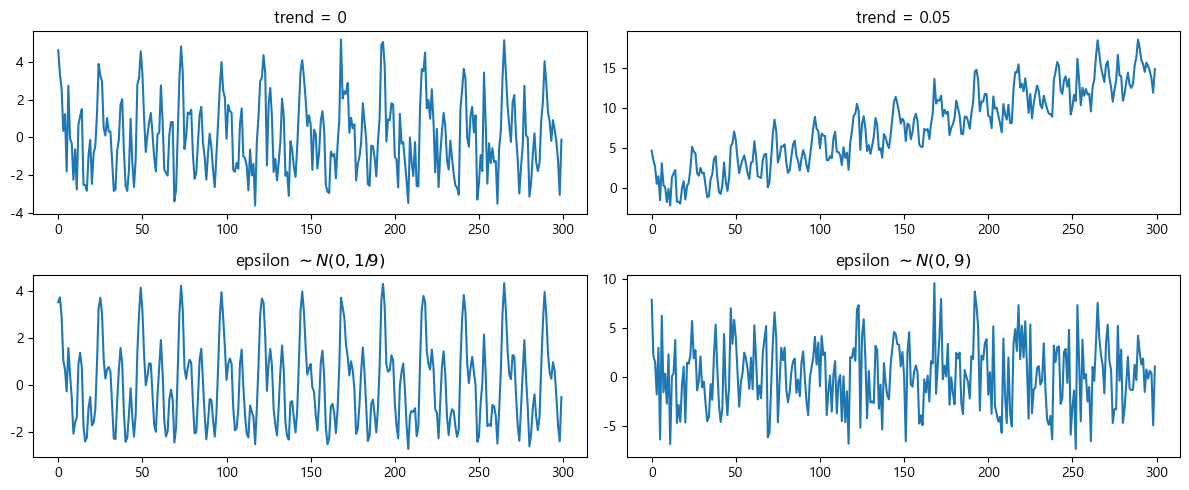

In [1018]:
fig, axe = plt.subplots(2,2,figsize = (12,5))
n = 300
axe[0,0].plot(simul_no_trend[:n] )
axe[0,0].set_title('trend = 0')
axe[0,1].plot(simul_yes_trend[:n])
axe[0,1].set_title('trend = 0.05')


axe[1,0].plot(simul_low_epsilon[:n])
axe[1,0].set_title('epsilon $\sim N(0,1/9)$')
axe[1,1].plot(simul_high_epsilon[:n] )
axe[1,1].set_title('epsilon $\sim N(0,9)$')

plt.tight_layout()
plt.show()

## 1. 샘플사이즈에 따른 적절한 에포크
- 배치사이즈 = 4로 고정
- 에포크 20으로 실험

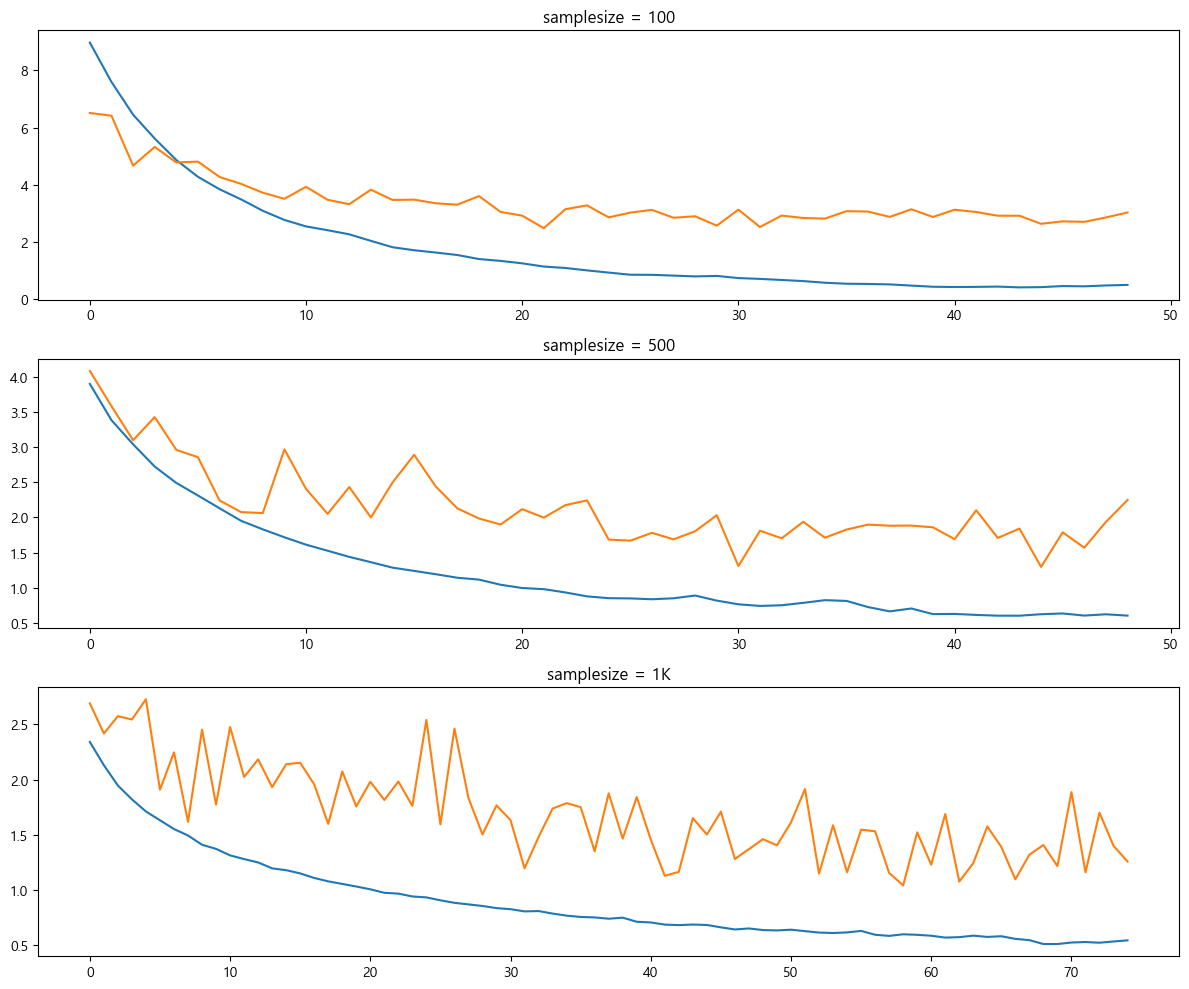

In [844]:
fig, axe = plt.subplots(3,1,figsize = (12,10))

axe[0].plot(history1.history['loss'][5:])
axe[0].plot(history1.history['val_loss'][5:100])
axe[0].set_title('samplesize = 100')


axe[1].plot(history2.history['loss'][5:100])
axe[1].plot(history2.history['val_loss'][5:100])
axe[1].set_title('samplesize = 500')


axe[2].plot(history3.history['loss'][5:100])
axe[2].plot(history3.history['val_loss'][5:100])
axe[2].set_title('samplesize = 1K')



 
#axe[1,1].plot(simul_high_epsilon[:n] )
#axe[1,1].set_title('epsilon $\sim N(0,9)$')

plt.tight_layout()
plt.show()

---
## 2. 추세의 유무에 따른 모델의 예측 결과

In [874]:
trend_yes_df = pd.DataFrame(np.array([nbeats_nt100_score,lstm_nt100_score,nbeats_nt500_score,lstm_nt500_score, nbeats_nt1000_score,lstm_nt1000_score]).mean(axis=1),)
trend_no_df = pd.DataFrame(np.array([nbeats_yt100_score,lstm_yt100_score,nbeats_yt500_score,lstm_yt500_score, nbeats_yt1000_score,lstm_yt1000_score]).mean(axis=1))

### 2.1 추세성 x , 샘플사이즈에 따른 평가지표

In [879]:
index = ["nbeats_nt100","lstm_nt100","nbeats_nt500","lstm_nt500","nbeats_nt1000","lstm_nt1000"] 
col = ["MSE","MAE","MAPE"]
trend_yes_df.columns = col
trend_yes_df.index = index 
trend_yes_df

,MSE,MAE,MAPE
nbeats_nt100,3.613097,1.455041,1.265595
lstm_nt100,1.480755,1.045031,1.148190
nbeats_nt500,2.375933,1.181373,1.478411
lstm_nt500,1.567744,1.005760,1.235922
nbeats_nt1000,1.806433,1.083535,1.174112
lstm_nt1000,2.312494,1.214724,1.198991


### 2.1.1 예측그래프

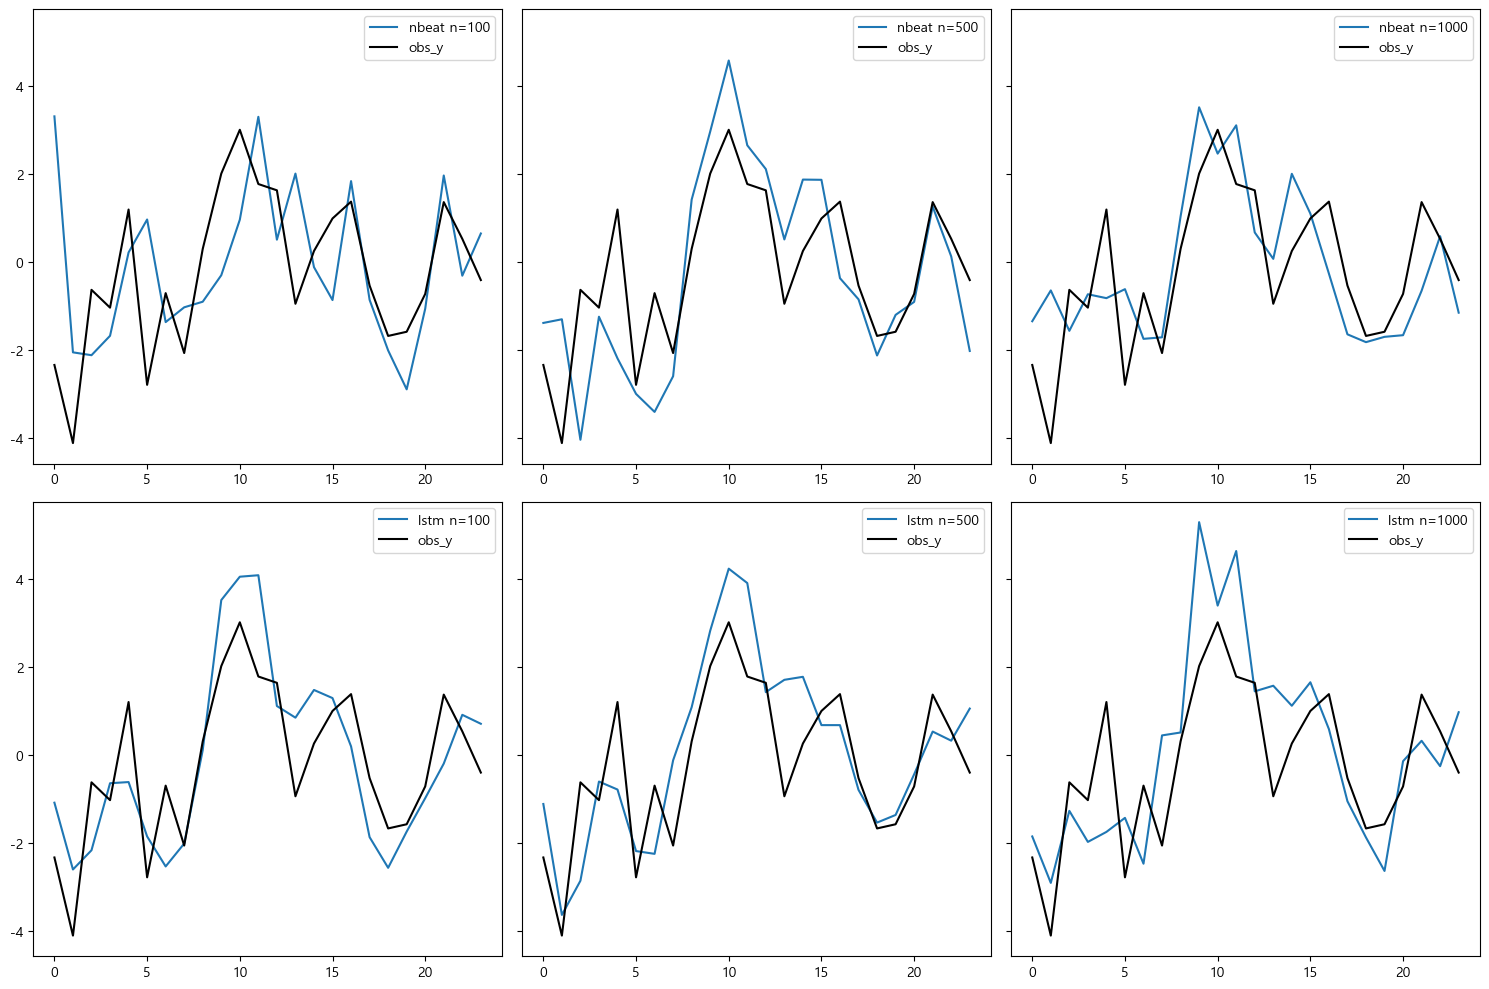

In [943]:
data_lists = [nbeats_nt100_lst[0], nbeats_nt500_lst[0], nbeats_nt1000_lst[0], lstm_nt100_lst[0], lstm_nt500_lst[0], lstm_nt1000_lst[0]]
labels = ['nbeat n=100', 'nbeat n=500', 'nbeat n=1000', 'lstm n=100', 'lstm n=500', 'lstm n=1000']

fig, axes = plt.subplots(2, 3, sharey=True, figsize=(15, 10))

for i, ax in enumerate(axes.flat):
    ax.plot(data_lists[i], label=labels[i])
    ax.plot(y_test_nt100[0].flatten(), label='obs_y', color='black')
    ax.legend()

plt.tight_layout()
plt.show()

### 2.2 추세성 x , 샘플사이즈에 따른 평가지표

In [888]:
index = ["nbeats_yt100","lstm_yt100","nbeats_yt500","lstm_yt500","nbeats_yt1000","lstm_yt1000"] 
col = ["MSE","MAE","MAPE"]
trend_no_df.columns = col
trend_no_df.index = index 
trend_no_df

,MSE,MAE,MAPE
nbeats_yt100,8.002481,2.317773,0.039304
lstm_yt100,93.314870,9.486682,0.160762
nbeats_yt500,3.720110,1.504744,0.025797
lstm_yt500,17.702714,3.859286,0.064905
nbeats_yt1000,1.439743,1.052351,0.018002
lstm_yt1000,13.306174,3.321512,0.055844


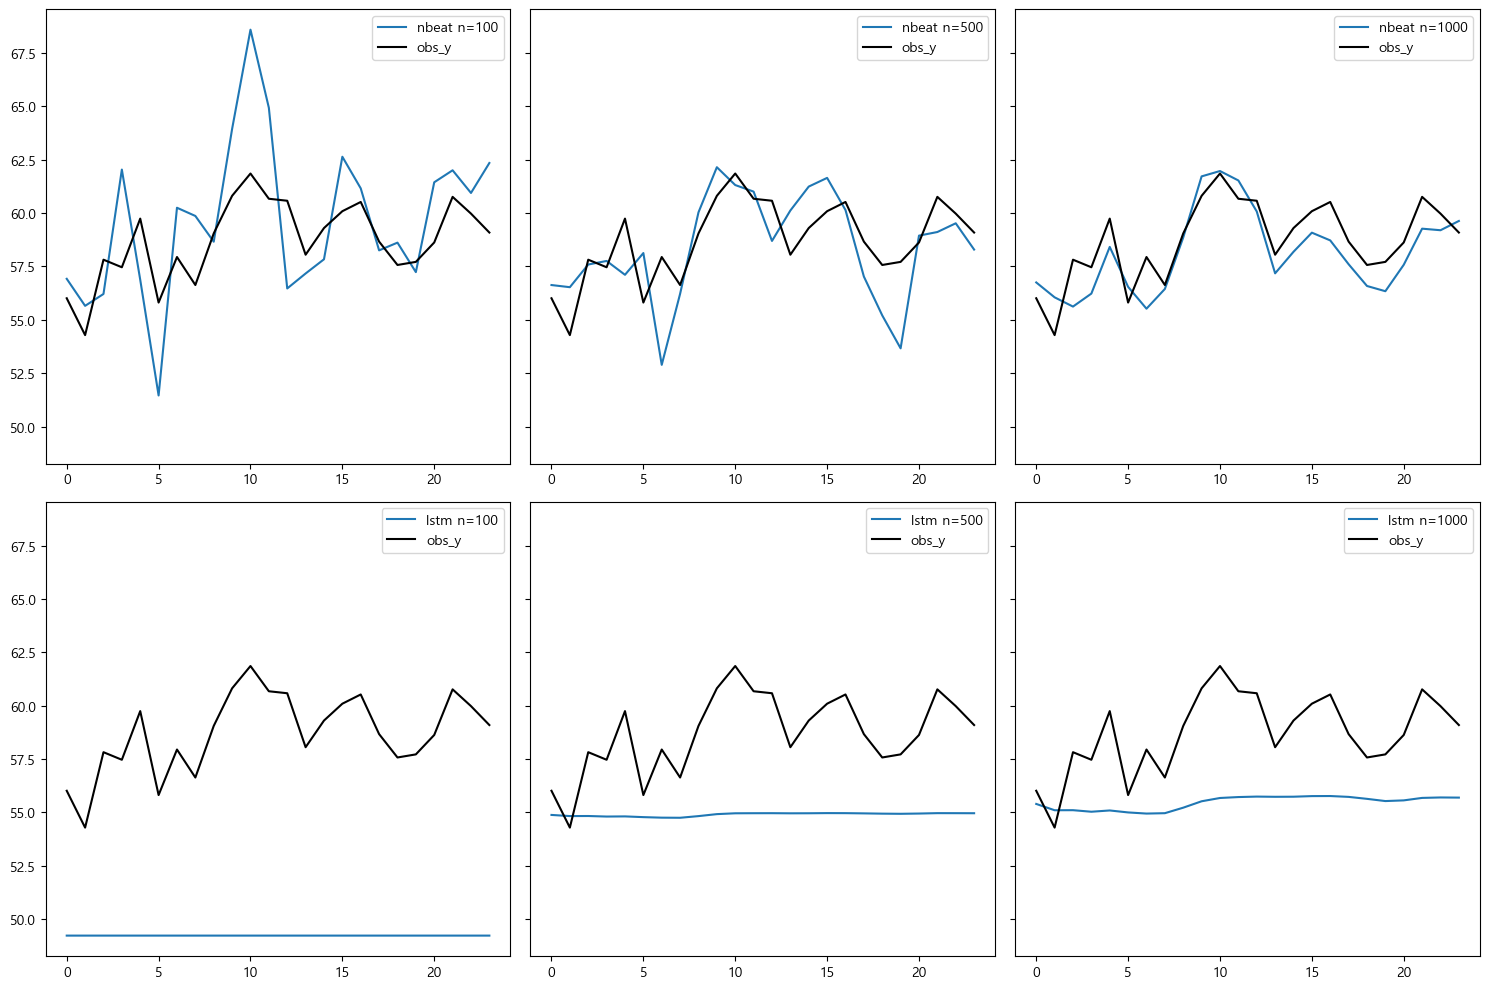

In [945]:
data_lists = [nbeats_yt100_lst[0], nbeats_yt500_lst[0], nbeats_yt1000_lst[0], lstm_yt100_lst[0], lstm_yt500_lst[0], lstm_yt1000_lst[0]]
labels = ['nbeat n=100', 'nbeat n=500', 'nbeat n=1000', 'lstm n=100', 'lstm n=500', 'lstm n=1000']

fig, axes = plt.subplots(2, 3, sharey=True, figsize=(15, 10))

for i, ax in enumerate(axes.flat):
    ax.plot(data_lists[i], label=labels[i])
    ax.plot(y_test_yt100[0].flatten(), label='obs_y', color='black')
    ax.legend()

plt.tight_layout()
plt.show()

---
## 3. 잔차 분산 크기에 따른 모델의 예측 결과

In [890]:
e_low_df = pd.DataFrame(np.array([nbeats_le100_score,lstm_le100_score,nbeats_le500_score,lstm_le500_score, nbeats_le1000_score,lstm_le1000_score]).mean(axis=1),)
e_high_df = pd.DataFrame(np.array([nbeats_he100_score,lstm_he100_score,nbeats_he500_score,lstm_he500_score, nbeats_he1000_score,lstm_he1000_score]).mean(axis=1))

### 3.1 $\epsilon \sim N(0,\frac{1}{3^2})$

In [891]:
index = ["nbeats_100","lstm_100","nbeats_500","lstm_500","nbeats_1000","lstm_1000"] 
col = ["MSE","MAE","MAPE"]
e_low_df.columns = col
e_low_df.index = index 
e_low_df

,MSE,MAE,MAPE
nbeats_100,2.771699,1.228790,3.743682
lstm_100,0.142649,0.305056,0.887489
nbeats_500,0.309257,0.422700,0.570390
lstm_500,0.110354,0.264421,0.749970
nbeats_1000,0.174294,0.341628,1.148228
lstm_1000,0.110834,0.276425,0.792737


### 3.1.1 예측 그래프

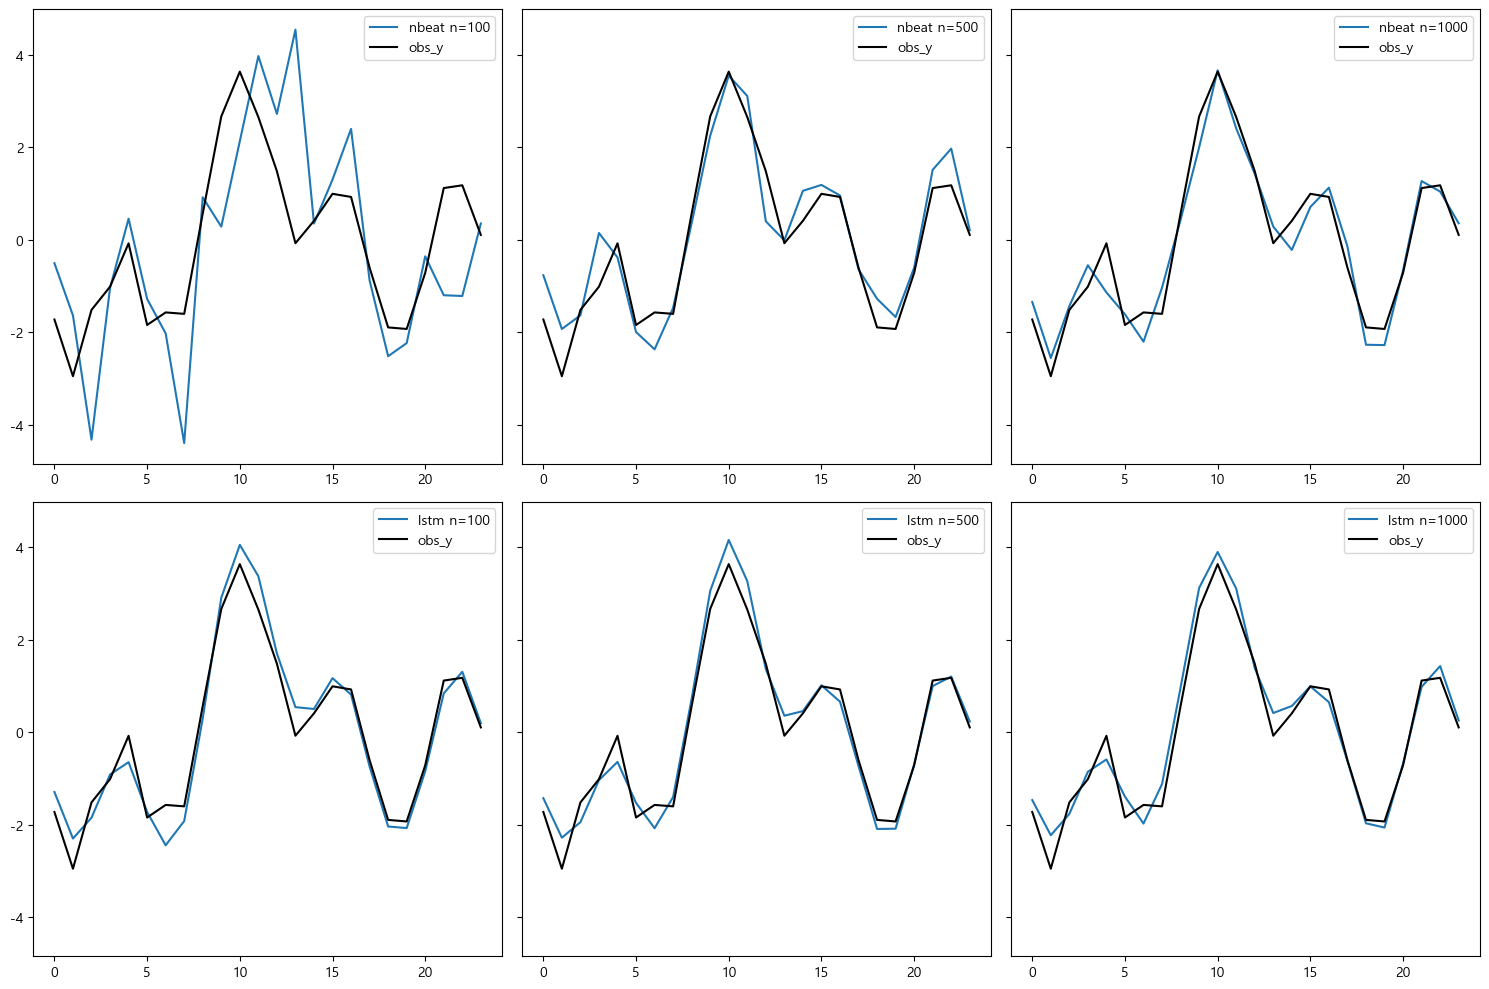

In [942]:
data_lists = [nbeats_le100_lst[0], nbeats_le500_lst[0], nbeats_le1000_lst[0], lstm_le100_lst[0], lstm_le500_lst[0], lstm_le1000_lst[0]]
labels = ['nbeat n=100', 'nbeat n=500', 'nbeat n=1000', 'lstm n=100', 'lstm n=500', 'lstm n=1000']

fig, axes = plt.subplots(2, 3, sharey=True, figsize=(15, 10))

for i, ax in enumerate(axes.flat):
    ax.plot(data_lists[i], label=labels[i])
    ax.plot(y_test_le100[0].flatten(), label='obs_y', color='black')
    ax.legend()

plt.tight_layout()
plt.show()

### 3.2 $\epsilon \sim N(0,3^2)$

In [892]:
index = ["nbeats_100","lstm_100","nbeats_500","lstm_500","nbeats_1000","lstm_1000"] 
col = ["MSE","MAE","MAPE"]
e_high_df .columns = col
e_high_df .index = index 
e_high_df 

,MSE,MAE,MAPE
nbeats_100,46.614640,5.788960,15.215589
lstm_100,17.535393,3.350398,7.327084
nbeats_500,13.832808,3.148616,4.399201
lstm_500,16.003760,3.324020,5.680933
nbeats_1000,8.995822,2.170681,2.633246
lstm_1000,21.151164,3.767821,7.340708


### 3.2.1 예측그래프

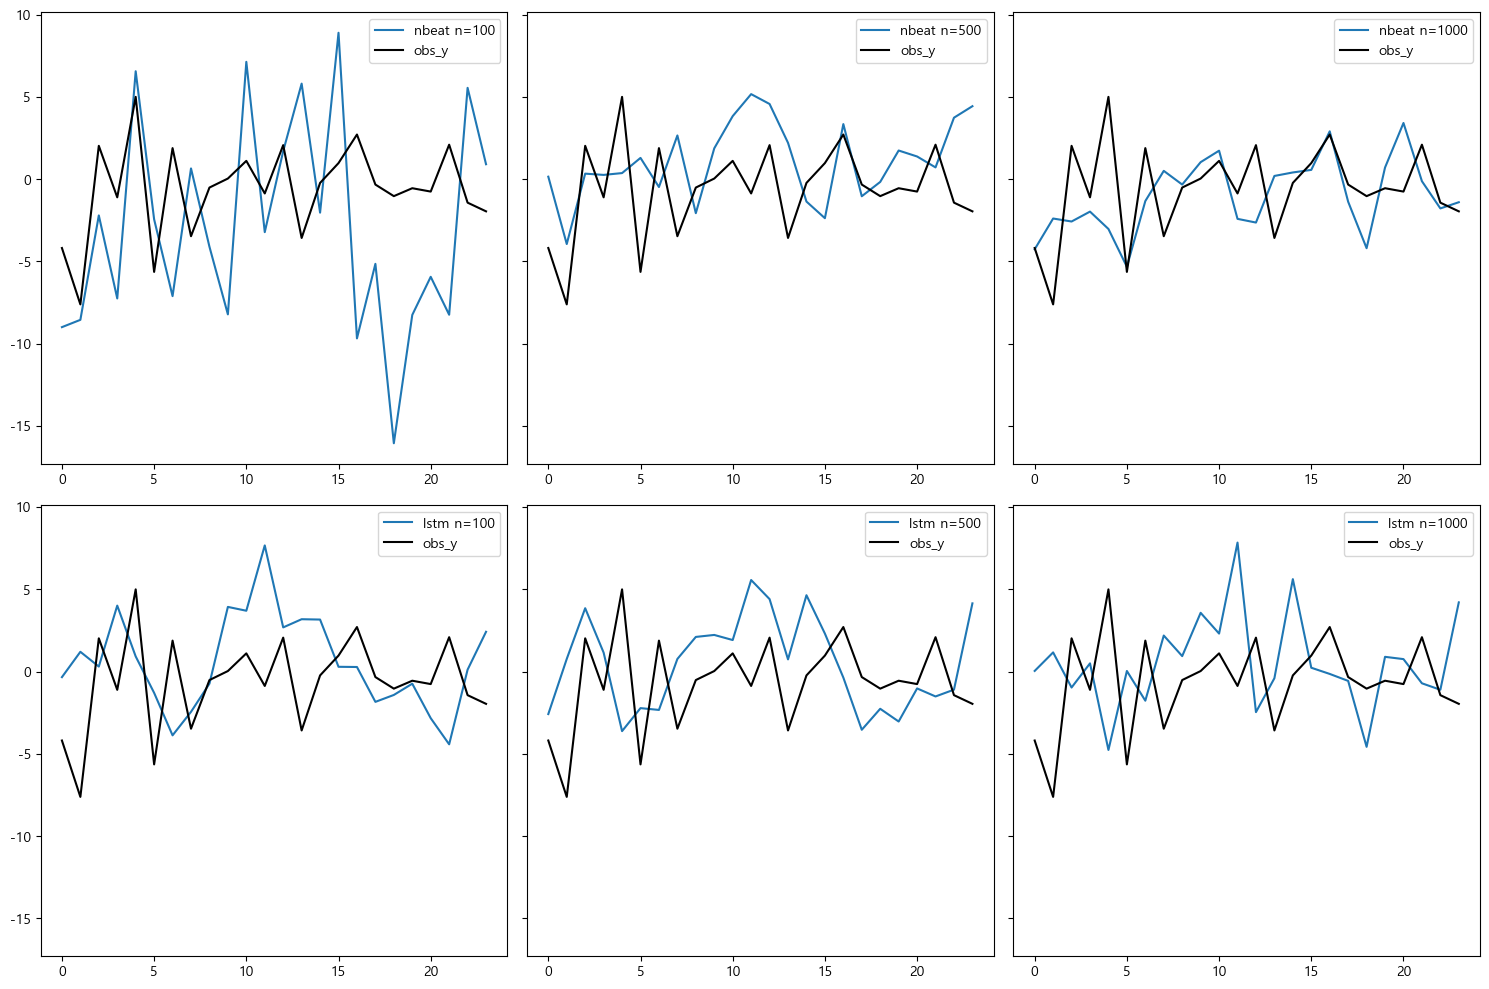

In [938]:
data_lists = [nbeats_he100_lst[0], nbeats_he500_lst[0], nbeats_he1000_lst[0], lstm_he100_lst[0], lstm_he500_lst[0], lstm_he1000_lst[0]]
labels = ['nbeat n=100', 'nbeat n=500', 'nbeat n=1000', 'lstm n=100', 'lstm n=500', 'lstm n=1000']

fig, axes = plt.subplots(2, 3, sharey=True, figsize=(15, 10))

for i, ax in enumerate(axes.flat):
    ax.plot(data_lists[i], label=labels[i])
    ax.plot(y_test_he100[0].flatten(), label='obs_y', color='black')
    ax.legend()

plt.tight_layout()
plt.show()
